<a href="https://colab.research.google.com/github/seoes/odyssey-ai/blob/seo/supervision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기본 설정

## 첫 설정

In [72]:
import torch
from PIL import Image
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Supervision 설치

In [73]:
!pip install supervision

from IPython.display import clear_output, display, Image
import io

import supervision as sv

## YOLOv5 설치 후 모델 불러오기

In [74]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Cloning into 'yolov5'...
remote: Enumerating objects: 16031, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 16031 (delta 36), reused 42 (delta 25), pack-reused 15967
Receiving objects: 100% (16031/16031), 14.67 MiB | 11.05 MiB/s, done.
Resolving deltas: 100% (10998/10998), done.
/content/yolov5/yolov5


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-11-1 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 80.5MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


# YOLOv8 설치 후 모델 불러오기

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

100%|██████████| 6.23M/6.23M [00:00<00:00, 97.9MB/s]


# 샘플 mp4 영상 다운로드 후 경로 설정

In [75]:
import os
HOME = os.getcwd()
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vVrEVMxucHgqGd7vAa501ASojbeGPhIr' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1vVrEVMxucHgqGd7vAa501ASojbeGPhIr" -O market-square.mp4 && rm -rf /tmp/cookies.txt
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=10pVQ9rSIJOOV69J8zkp9svozXfaa7-4w' -O sample_mall.mp4


# SAMPLE_VIDEO_PATH = f"{HOME}/sample_mall.mp4"
SAMPLE_VIDEO_PATH = f"{HOME}/market-square.mp4"
SAMPLE_IMAGE_PATH = f"{HOME}/sample_photo.png"

/content/yolov5/yolov5
--2023-11-01 05:32:23--  https://docs.google.com/uc?export=download&confirm=&id=1vVrEVMxucHgqGd7vAa501ASojbeGPhIr
Resolving docs.google.com (docs.google.com)... 108.177.13.102, 108.177.13.138, 108.177.13.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.13.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/sl0ibm42i390hhou3aiq6ukr8sik08h6/1698816675000/04309230031174164349/*/1vVrEVMxucHgqGd7vAa501ASojbeGPhIr?e=download&uuid=25f067d8-610c-4a0b-900a-cef160bcfcc4 [following]
--2023-11-01 05:32:24--  https://doc-0k-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/sl0ibm42i390hhou3aiq6ukr8sik08h6/1698816675000/04309230031174164349/*/1vVrEVMxucHgqGd7vAa501ASojbeGPhIr?e=download&uuid=25f067d8-610c-4a0b-900a-cef160bcfcc4
Resolving doc-0k-ag-docs.googleusercontent.com (doc-0k-ag-docs.googleusercontent.co

# 영상 분석

## 준비

In [76]:
# 색 설정
colors = sv.ColorPalette.default()

# 비디오 파일 정보 추출
video_info = sv.VideoInfo.from_video_path(SAMPLE_VIDEO_PATH)

## Polygon 형태로 구역 나누기

## Polygon - 구역별

In [77]:
polygons = [
    np.array([ # 상단
        [0,0],
        [0,882],
        [384,772],
        [713,707],
        [1150,683],
        [1490,715],
        [2160,588],
        [2160,0]
    ], np.int32),
    np.array([ # 중앙 광장
        [0,882],
        [384,772],
        [713,707],
        [1150,683],
        [1490,715],
        [2160,588],
        [2160,2981],
        [2006,3030],
        [1722,3113],
        [1300,3150],
        [915,3133],
        [456,3060],
        [0,2890],

    ], np.int32),
    np.array([ # 분수대
        [648,1304],
        [840, 1130],
        [1123,1076],
        [1400,1100],
        [1581,1335],
        [1545,1545],
        [1284,1738],
        [920,1727],
        [645,1521]
    ], np.int32),
    np.array([ # 하단
        [0,2890],
        [456,3060],
        [915,3133],
        [1300,3150],
        [1722,3113],
        [2006,3030],
        [2160,2981],
        [2160,3840],
        [0,3840]
    ], np.int32)
]

## Polygon - 무작위 구역

In [ ]:
# numpy의 배열 형식으로 다각형의 폴리곤 형태 정의
polygons = [
    np.array([
        [540,  985 ],
        [1620, 985 ],
        [2160, 1920],
        [1620, 2855],
        [540,  2855],
        [0,    1920]
    ], np.int32),
    np.array([
        [0,    1920],
        [540,  985 ],
        [0,    0   ]
    ], np.int32),
    np.array([
        [1620, 985 ],
        [2160, 1920],
        [2160,    0]
    ], np.int32),
    np.array([
        [540,  985 ],
        [0,    0   ],
        [2160, 0   ],
        [1620, 985 ]
    ], np.int32),
    np.array([
        [0,    1920],
        [0,    3840],
        [540,  2855]
    ], np.int32),
    np.array([
        [2160, 1920],
        [1620, 2855],
        [2160, 3840]
    ], np.int32),
    np.array([
        [1620, 2855],
        [540,  2855],
        [0,    3840],
        [2160, 3840]
    ], np.int32)
]




# Zone 선언

In [78]:
zones = [
    sv.PolygonZone(
        polygon=polygon,
        frame_resolution_wh=video_info.resolution_wh
    )
    for polygon
    in polygons
]
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=8,
        text_thickness=8,
        text_scale=4
    )
    for index, zone
    in enumerate(zones)
]
bounding_box_annotators = [
    sv.BoundingBoxAnnotator(
        color=colors.by_idx(index),
        thickness=6
        )
    for index
    in range(len(polygons))
]
label_annotators = [
    sv.LabelAnnotator(
        color=colors.by_idx(index),
        text_thickness=4,
        text_scale=2
    )
    for index
    in range(len(polygons))
]
ellipse_annotators = [
    sv.EllipseAnnotator(
      color=colors.by_idx(index),
      thickness=4,
      )
    for index
    in range(len(polygons))
]
trace_annotators = [
    sv.TraceAnnotator(
      color=colors.by_idx(index),
      trace_length=50,
      thickness=4
    )
    for index
    in range(len(polygons))
]
mask_annotators = [
    sv.MaskAnnotator(
      color=colors.by_idx(index),
    )
    for index
    in range(len(polygons))
]
halo_annotators = [
    sv.HaloAnnotator(
      color=colors.by_idx(index),
    )
    for index
    in range(len(polygons))
]

## 인식

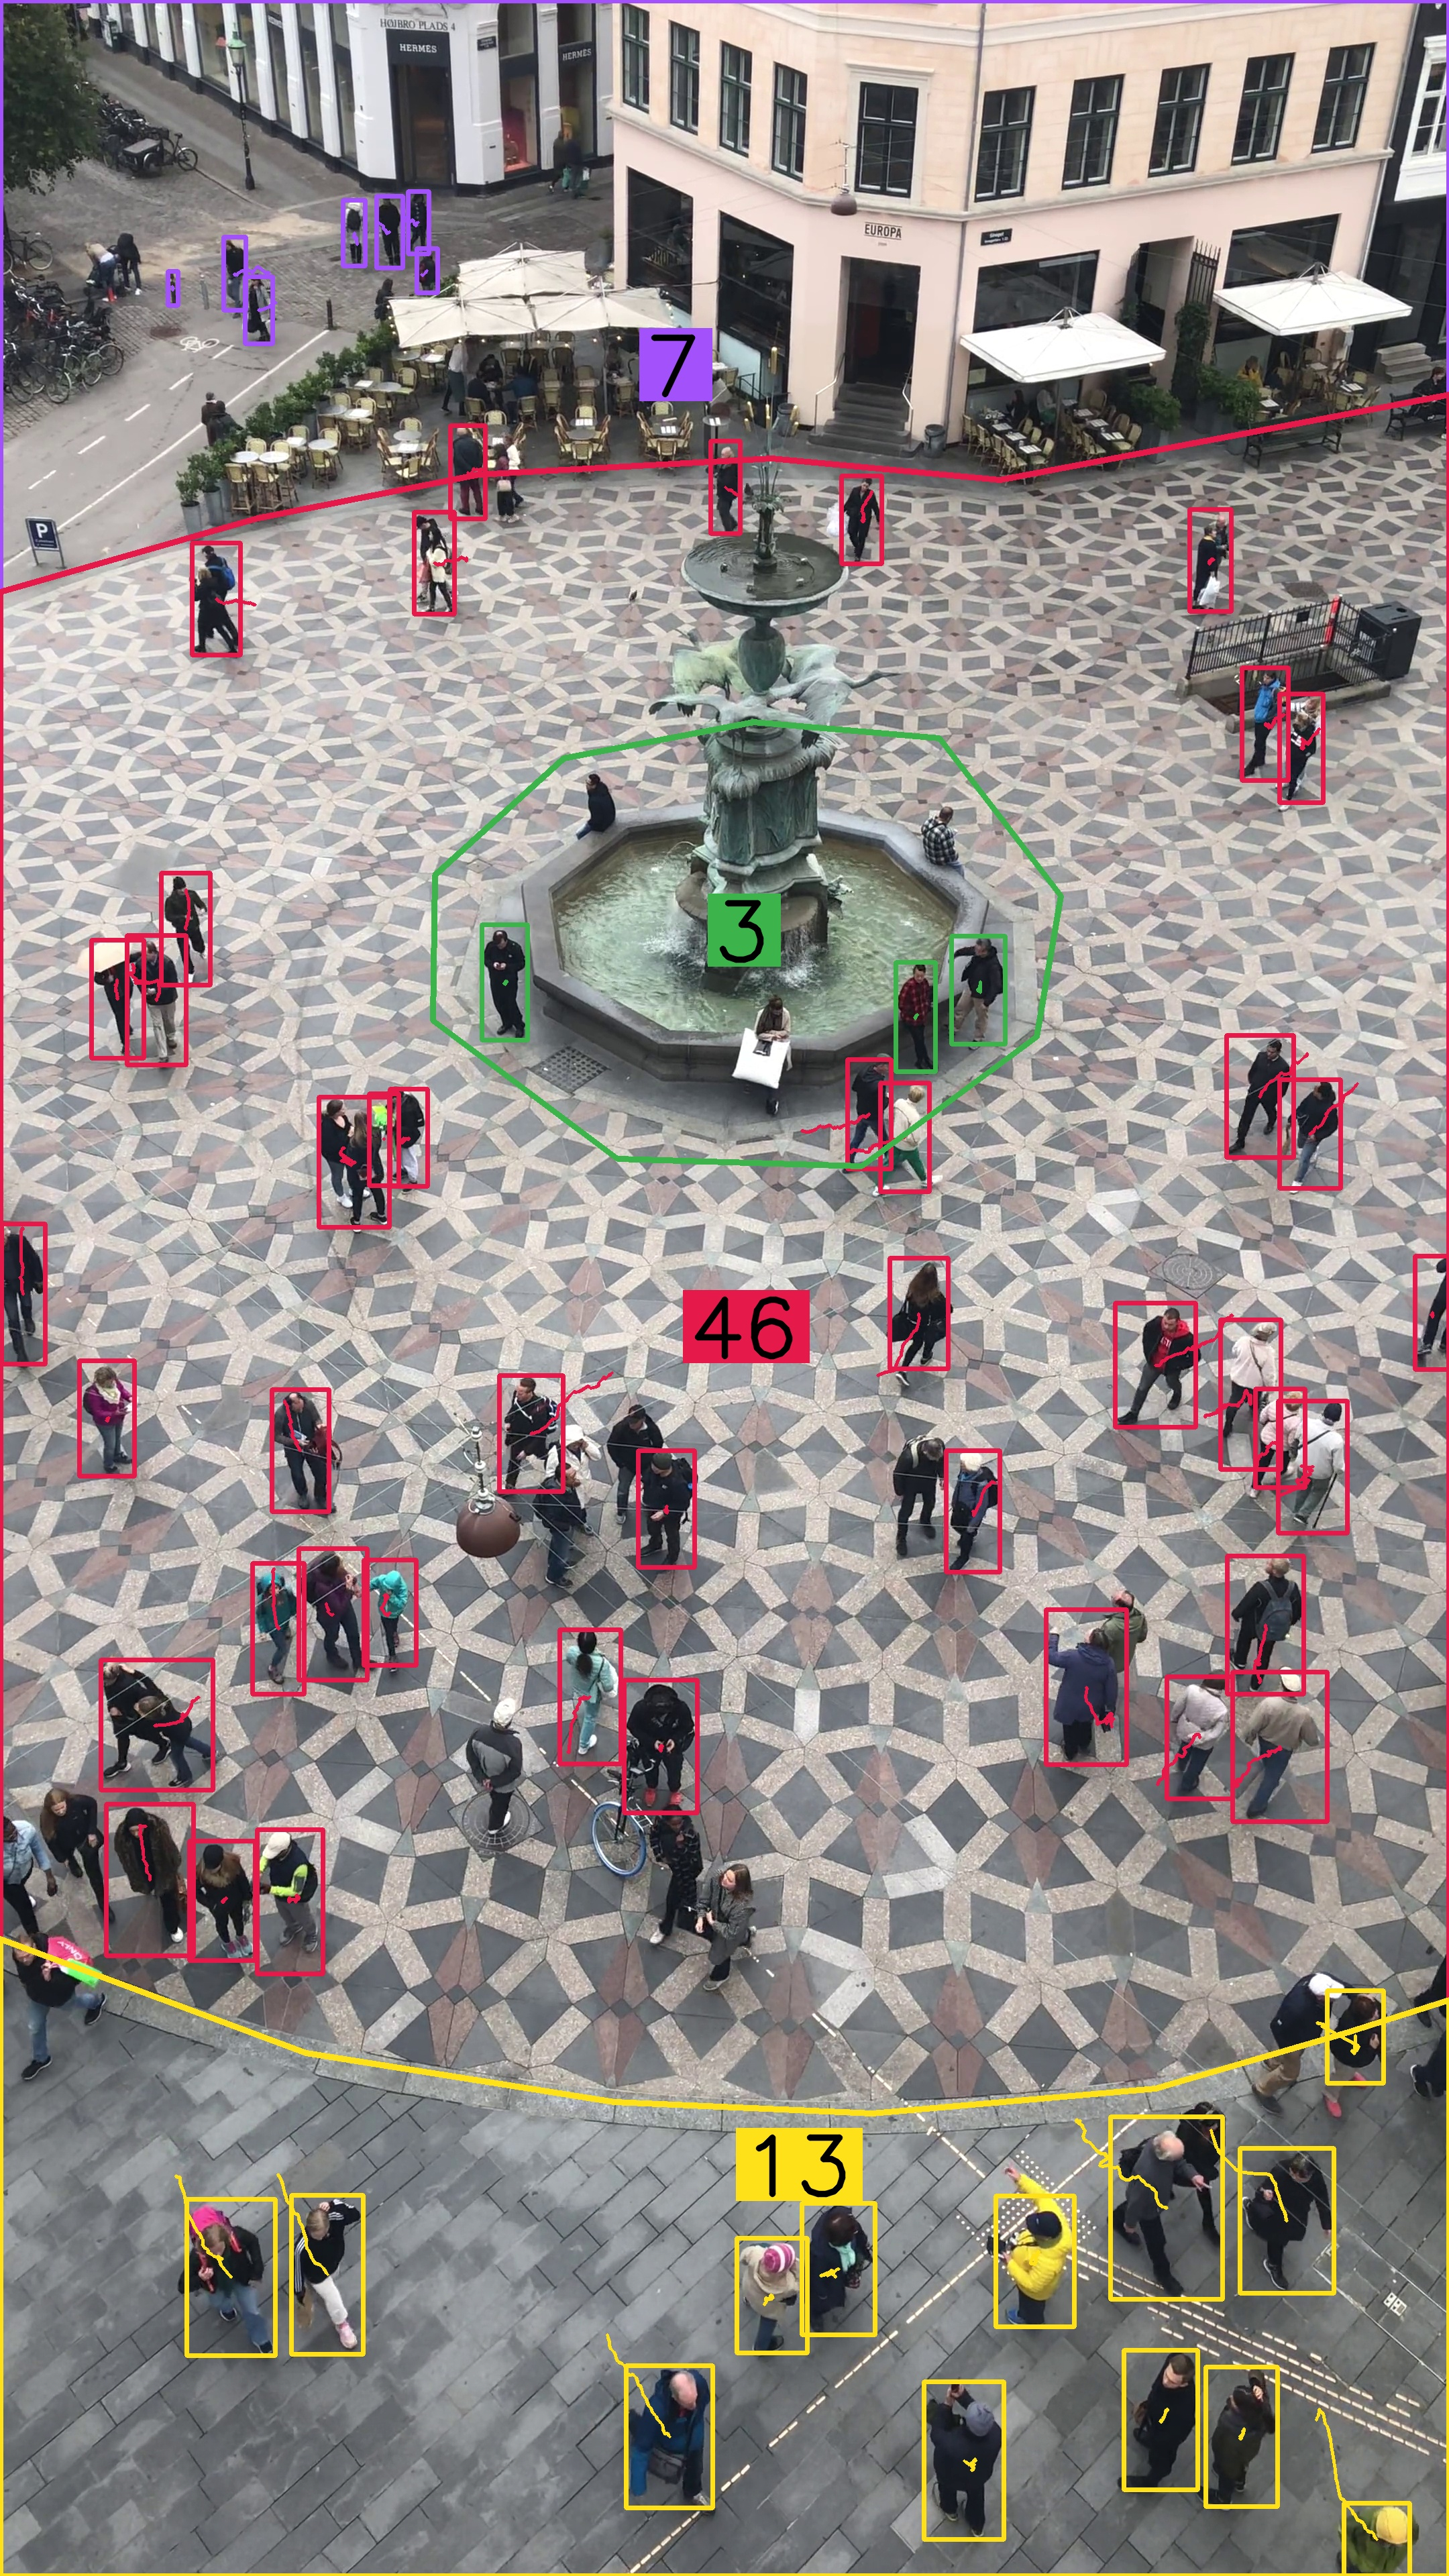

Processing frame 254...


In [ ]:
tracker = sv.ByteTrack()

# 각 zone에 대한 체류 시간을 저장하는 2차원 배열 초기화
zone_durations = [[] for _ in range(len(polygons))]
total_people = 0

def process_frame(frame: np.ndarray, i) -> np.ndarray:
  # if i < 24:
    print(f"Processing frame {i}...")

    # 탐지
    results = model(frame, size=1280)
    detections = sv.Detections.from_yolov5(results)
    detections = detections[(detections.class_id == 0) & (detections.confidence > 0.2)]
    detections = tracker.update_with_detections(detections)

    # 전체 사람 수를 누적
    global total_people
    total_people += len(detections)

    labels = [
      "person"
      # results.names[class_id]
      for class_id
      in detections.class_id
    ]

    for idx, (zone, zone_annotator, halo_annotator,ellipse_annotator, trace_annotator,  mask_annotator, box_annotator, label_annotator) in enumerate(zip(zones, zone_annotators,halo_annotators, ellipse_annotators, trace_annotators,  mask_annotators, bounding_box_annotators, label_annotators)):
        mask = zone.trigger(detections=detections)
        detections_filtered = detections[mask]
        frame = mask_annotator.annotate(scene=frame.copy(), detections=detections_filtered)
        frame = halo_annotator.annotate(scene=frame.copy(), detections=detections_filtered)
        frame = trace_annotator.annotate(scene=frame.copy(), detections=detections_filtered)
        # frame = ellipse_annotator.annotate(scene=frame.copy(), detections=detections_filtered)
        frame = box_annotator.annotate(scene=frame.copy(), detections=detections_filtered)
        # frame = label_annotator.annotate(scene=frame.copy(), detections=detections_filtered, labels=labels)
        frame = zone_annotator.annotate(scene=frame.copy())

        # 현재 프레임에서 해당 zone에서 감지된 사람의 수를 배열에 추가
        zone_durations[idx].append(len(detections_filtered))

    # for idx, (zone, zone_annotator, box_annotator) in enumerate(zip(zones, zone_annotators, box_annotators)):
    #     mask = zone.trigger(detections=detections)
    #     detections_filtered = detections[mask]
    #     frame = box_annotator.annotate(scene=frame, detections=detections_filtered, skip_label=True)
    #     frame = zone_annotator.annotate(scene=frame)

    #     # 현재 프레임에서 해당 zone에서 감지된 사람의 수를 배열에 추가
    #     zone_durations[idx].append(len(detections_filtered))

    # 실시간으로 프레임 출력
    clear_output(wait=True)
    _, buffer = cv2.imencode('.jpg', frame)
    display(Image(data=buffer.tobytes()))

    return frame


# mp4 파일로 출력
sv.process_video(source_path=SAMPLE_VIDEO_PATH, target_path=f"{HOME}/market-square-result.mp4", callback=process_frame)

for idx, durations in enumerate(zone_durations):
    ratio = sum(durations)/total_people * 100
    print(f"Zone {idx + 1} total duration: {ratio:.1f}%")





# 24 프레임만 출력
# for i in range(24):
#     frame = next(iterator)
#     _, buffer = cv2.imencode('.jpg', frame)
#     display(Image(data=buffer.tobytes()))


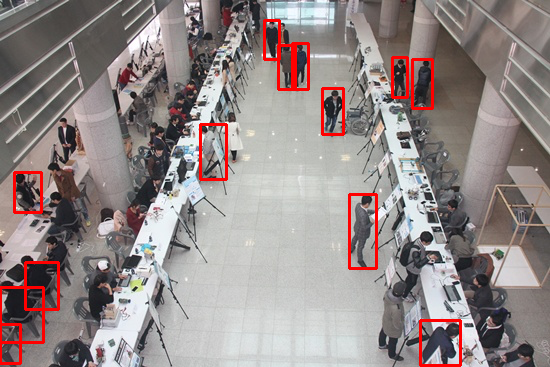

In [ ]:
from google.colab.patches import cv2_imshow

# 이미지 불러오기
image = cv2.imread(SAMPLE_IMAGE_PATH)

results = model(image)
person_boxes = results.pandas().xyxy[0]

for box in person_boxes.values:
  x1, y1, x2, y2, _, _, _ = box
  cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
cv2_imshow(image)